In [1]:
!pip install yellowbrick
!pip install tensorflow
import os
os.environ["OMP_NUM_THREADS"] = "9"
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,accuracy_score,classification_report


# TensorFlow and Keras for deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Sklearn for data splitting and evaluation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
#Read the data
pd.set_option('display.max_rows',None)
df=pd.read_csv('./HAM10000_metadata.csv')
df.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [3]:
#print the data shape
shape=df.shape
print(f'Dataset contains {shape[0]} rows and {shape[1]} columns')

Dataset contains 10015 rows and 7 columns


In [4]:
#obtain key details of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [5]:
#check for dupplicate data
df.duplicated().sum()

0

In [6]:
#check for unique counts in the data 
df.describe(include= 'object').T

count unique           top  freq
lesion_id     10015   7470   HAM_0003789     6
image_id      10015  10015  ISIC_0027419     1
dx            10015      7            nv  6705
dx_type       10015      4         histo  5340
sex           10015      3          male  5406
localization  10015     15          back  2192

In [7]:
#check for duplicates in the lesion_id column
df['lesion_id'].duplicated().sum()

2545

In [8]:
#drop duplicates in the lesion_id column
df = df.drop_duplicates(subset='lesion_id')

In [9]:
#check for the new data shape
df.shape

(7470, 7)

In [10]:
#describe the data
df.describe().T

count       mean        std  min   25%   50%   75%   max
age  7418.0  51.658803  16.016472  0.0  40.0  50.0  65.0  85.0

In [11]:
#check for missing values
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             52
sex              0
localization     0
dtype: int64

In [12]:
#obtain the percentage missing values
percent_missing_values=df.isnull().mean()*100
percent_missing_values.sort_values(ascending=False)

age             0.696118
lesion_id       0.000000
image_id        0.000000
dx              0.000000
dx_type         0.000000
sex             0.000000
localization    0.000000
dtype: float64

In [13]:
#assign other values that could be missing
missing_values=['NA','na','n/a','N/A','','null','-']
for column in df.columns:
    df[column]=df[column].replace(missing_values,np.nan)

In [14]:
# Create a SimpleImputer instance for numeric columns
imputer = SimpleImputer(strategy='mean')

# Loop through the columns
for column in df.columns:
    if df[column].dtype in ['int64', 'float64']:
        df[[column]] = imputer.fit_transform(df[[column]])

# Check for any remaining null values
print(df.isnull().sum())

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64


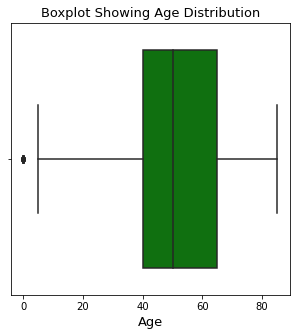

In [15]:
#box plot for outliers
plt.figure(figsize=(5,5))  # Adjusted to a more standard height
sns.boxplot(x=df['age'], color='green')  # Use 'x=' instead of passing the Series as a positional argument
plt.title('Boxplot Showing Age Distribution', fontsize=13)  # Fixed typo: 'Boxplt' → 'Boxplot'
plt.xlabel('Age', fontsize=13)  # Optional: Label the axis
plt.savefig(f'outlier.jpg')
plt.show()

## DATA VISUALIZATION

In [16]:
#create a function to handle pie-chart
import matplotlib.pyplot as plt
#create the plot
def pie_chart(df, column_name):
    if column_name in df.columns:
        value_counts=df[column_name].value_counts()
        plt.figure(figsize=(5,5))
        plt.pie(value_counts,labels=value_counts.index,autopct='%1.1f%%')
        plt.title(f"{column_name} pie chart",fontsize=13)
        plt.xticks(rotation=60,fontsize=18)
        plt.axis('equal')
        plt.savefig(f'sex pie chart.jpg')
        plt.show()
    else:
        print(f"{column_name} is not in the data set")
#call the function
pie_chart(df, 'sex')

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
#bar chart for diganosis type distribution
plt.figure(figsize=(5,5))
sns.countplot(data=df, x='dx', order=df['dx'].value_counts().index, palette='viridis')
plt.title('Distribution of Diagnosis Types')
plt.xlabel('Diagnosis (dx)', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.xticks(rotation=45, fontsize=13) 
plt.tight_layout()
plt.savefig(f'Diagnosis Type.jpg')
plt.show()

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
#bar chart for diagnosis method distribution
plt.figure(figsize=(5,5))
sns.countplot(data=df, x='dx_type', order=df['dx_type'].value_counts().index, palette='Set2')
plt.title('Distribution of Diagnosis Method')
plt.xlabel('Diagnosis Method(dx_type)', fontsize=13)
plt.ylabel('Count',fontsize=13)
plt.xticks(rotation=45, fontsize=13) 
plt.tight_layout()
plt.savefig(f'Diagnosis Method.jpg')
plt.show()

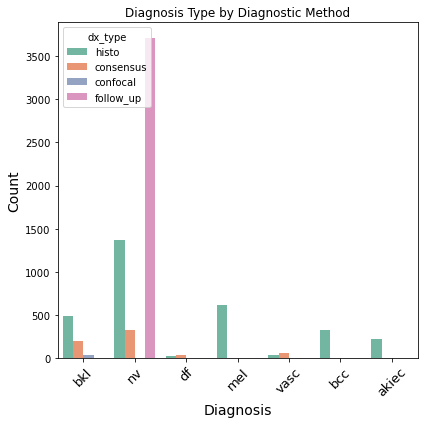

In [19]:
plt.figure(figsize=(6,6))
#countplot 
sns.countplot(data=df, x='dx', hue='dx_type', palette='Set2')
plt.title('Diagnosis Type by Diagnostic Method')
plt.xlabel('Diagnosis', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, fontsize=13)  # Increased font size
plt.tight_layout()
plt.savefig('Diagnosis Type by Diagnostic Method.jpg')
plt.show()

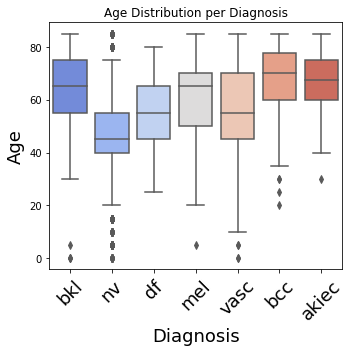

In [20]:
plt.figure(figsize=(5,5))
#box plot for age distribution
sns.boxplot(data=df, x='dx', y='age', palette='coolwarm')
plt.title('Age Distribution per Diagnosis')
plt.xlabel('Diagnosis', fontsize=18)
plt.ylabel('Age', fontsize=18)
plt.xticks(rotation=45, fontsize=18) 
plt.tight_layout()
plt.savefig(f'Age Distribution Per Diagnosis.jpg')
plt.show()

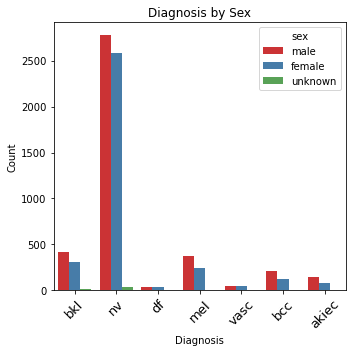

In [21]:
plt.figure(figsize=(5,5))
#bar chart for diagnosis by sex
sns.countplot(data=df, x='dx', hue='sex', palette='Set1')
plt.title('Diagnosis by Sex')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=45, fontsize=13) 
plt.tight_layout()
plt.savefig(f'Diagnosis by sex.jpg')
plt.show()

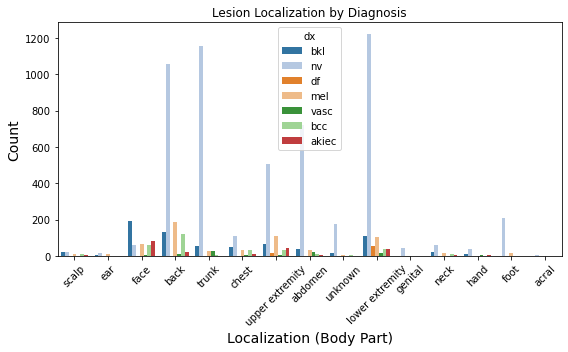

In [22]:
plt.figure(figsize=(8,5))
#bar chart for Lesion Localization by Diagnosis
sns.countplot(data=df, x='localization', hue='dx', palette='tab20')
plt.title('Lesion Localization by Diagnosis')
plt.xlabel('Localization (Body Part)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'Lesion Localization by Diagnosis.jpg')
plt.show()

In [23]:
plt.figure(figsize=(5,5))
#box plot for Age Distribution by Sex and Diagnosis
g = sns.catplot(
    data=df, x="dx", y="age", hue="sex",
    kind="box", height=6, aspect=2, palette="pastel"
)
g.set_titles("Age Distribution by Sex and Diagnosis")
g.set_axis_labels("Diagnosis", "Age", fontsize=18)
plt.xticks(rotation=45, fontsize=18) 
plt.yticks(rotation=45, fontsize=18) 
plt.tight_layout()
plt.savefig(f'Age Distribution by Sex and Diagnosis.jpg')
plt.show()

<Figure size 360x360 with 0 Axes>

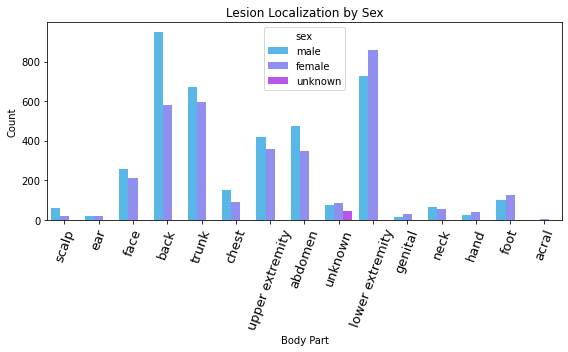

In [24]:
plt.figure(figsize=(8,5))
#count plot for Lesion Localization by Sex
sns.countplot(data=df, x='localization', hue='sex', palette='cool')
plt.title('Lesion Localization by Sex')
plt.xlabel('Body Part')
plt.ylabel('Count')
plt.xticks(rotation=70,fontsize=13)
plt.tight_layout()
plt.savefig(f'Lesion Localization by Sex.jpg')
plt.show()

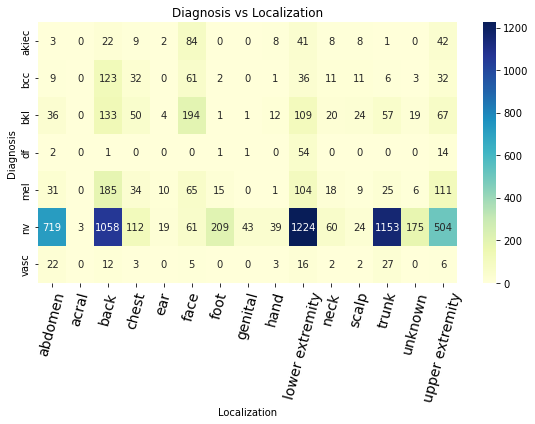

In [25]:
dx_loc = pd.crosstab(df['dx'], df['localization'])
#heat map for Diagnosis vs Localization
plt.figure(figsize=(8,6))
sns.heatmap(dx_loc, cmap="YlGnBu", annot=True, fmt="d")
plt.title('Diagnosis vs Localization')
plt.ylabel('Diagnosis')
plt.xlabel('Localization')
plt.xticks(rotation=75, fontsize=14) 
plt.tight_layout()
plt.savefig(f'Diagnosis vs Localization.jpg')
plt.show()

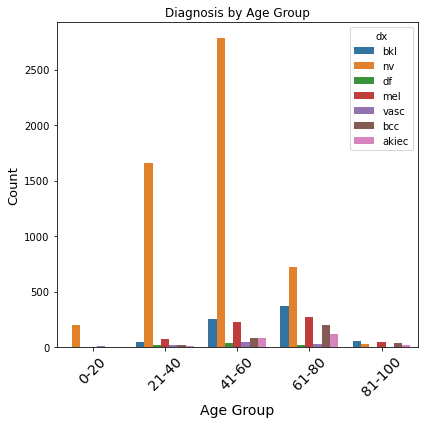

In [26]:
df['age_group'] = pd.cut(df['age'], bins=[0, 20, 40, 60, 80, 100], labels=['0-20','21-40','41-60','61-80','81-100'])

plt.figure(figsize=(6,6))
#countplot for Diagnosis by Age Group
sns.countplot(data=df, x='age_group', hue='dx', palette='tab10')
plt.title('Diagnosis by Age Group')
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Count', fontsize=13)
plt.xticks(rotation=45, fontsize=14) 
plt.tight_layout()
plt.savefig(f'Diagnosis by Age Group.jpg')
plt.show()

In [27]:
dx_method = df.groupby(['dx_type', 'dx']).size().unstack().fillna(0)
#stacked bar chart for Diagnosis Distribution per Diagnostic Method
dx_method.plot(kind='bar', stacked=True, figsize=(6,6), colormap='Accent')
plt.title('Diagnosis Distribution per Diagnostic Method')
plt.ylabel('Count', fontsize=14)
plt.xlabel('Diagnostic Method', fontsize=13)
plt.xticks(rotation=15,fontsize=13)
plt.tight_layout()
plt.savefig(f'Diagnosis Distribution per Diagnostic Method.jpg')
plt.show()

In [28]:
#check the number of each item in the label
df['dx'].value_counts()

nv       5403
bkl       727
mel       614
bcc       327
akiec     228
vasc       98
df         73
Name: dx, dtype: int64

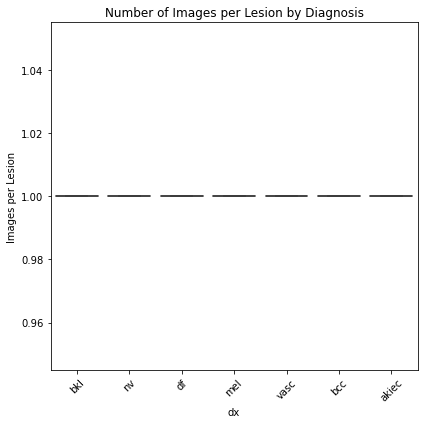

In [29]:
img_per_lesion = df.groupby('lesion_id').size()
df['images_per_lesion'] = df['lesion_id'].map(img_per_lesion)

plt.figure(figsize=(6,6))
sns.boxplot(data=df, x='dx', y='images_per_lesion', palette='muted')
plt.title('Number of Images per Lesion by Diagnosis')
plt.ylabel('Images per Lesion')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'Number of Images per Lesion by Diagnosis.jpg')
plt.show()

In [30]:
from sklearn.utils import resample

grouped = df.groupby('dx')
#code for undersampling and oversampling
balanced_list = []

for lable, group in grouped:
    sample_len = len(group)
    if sample_len < 300:
        #set the number of samples to be 300
         sampled = resample(group, replace=True, n_samples=300, random_state=40)
    elif sample_len > 300:
        sampled = resample(group, replace=False, n_samples=300, random_state=40)
    else:
        sampled = group 
    balanced_list.append(sampled)

#Combine and shuffle
df = pd.concat(balanced_list).sample(frac=1, random_state=40).reset_index(drop=True)
#show the first 5 data
df.head()

lesion_id      image_id     dx    dx_type   age     sex     localization  \
0  HAM_0000361  ISIC_0032199  akiec      histo  60.0  female             face   
1  HAM_0000720  ISIC_0028926     df      histo  65.0    male  upper extremity   
2  HAM_0004496  ISIC_0028651     df  consensus  55.0  female  lower extremity   
3  HAM_0006243  ISIC_0031436    bkl  consensus  75.0    male  upper extremity   
4  HAM_0007616  ISIC_0027373     nv  follow_up  55.0    male  lower extremity   

  age_group  images_per_lesion  
0     41-60                  1  
1     61-80                  1  
2     41-60                  1  
3     61-80                  1  
4     41-60                  1

In [31]:
#count the number of items in the label
df['dx'].value_counts()

akiec    300
df       300
bkl      300
nv       300
bcc      300
vasc     300
mel      300
Name: dx, dtype: int64

In [32]:
from sklearn.preprocessing import LabelEncoder
#encode the labels to numbers
encoder= LabelEncoder()
def LabelEncoding(df,column):
    df[column]=encoder.fit_transform(df[column])
    return df.head()
LabelEncoding(df,'dx')

lesion_id      image_id  dx    dx_type   age     sex     localization  \
0  HAM_0000361  ISIC_0032199   0      histo  60.0  female             face   
1  HAM_0000720  ISIC_0028926   3      histo  65.0    male  upper extremity   
2  HAM_0004496  ISIC_0028651   3  consensus  55.0  female  lower extremity   
3  HAM_0006243  ISIC_0031436   2  consensus  75.0    male  upper extremity   
4  HAM_0007616  ISIC_0027373   5  follow_up  55.0    male  lower extremity   

  age_group  images_per_lesion  
0     41-60                  1  
1     61-80                  1  
2     41-60                  1  
3     61-80                  1  
4     41-60                  1

In [33]:
import glob
image_dir =glob.glob("./HAM10000_images_part_1/*")

In [34]:
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

# `images` is a list of image file paths
fig, axs = plt.subplots(2, 6, figsize=(15, 5)) 

for i in range(12):
    row = i // 6
    col = i % 6
    idx = random.randint(0, len(image_dir) - 1)
    
    # Open with PIL and convert to RGB
    img = Image.open(image_dir[idx]).convert('RGB')
    
    # Convert to array for matplotlib
    img_np = np.array(img)
    
    axs[row, col].imshow(img_np)
    axs[row, col].axis('off')
    axs[row, col].set_title(f"Image {i+1} - ({img_np.shape})",fontsize=14)

plt.suptitle('Random RGB Images (Pillow)', fontsize=18, y=1.02)
plt.tight_layout()
plt.savefig(f'random images in file path.jpg')
plt.show()

In [35]:
#show the shape of the data 
df.shape

(2100, 9)

In [36]:
import os
from PIL import Image
import numpy as np

# Parameters
image_size = (28, 28)
images = []
labels = []

# Image folder path
# image_dir = r"C:\Users\user\Downloads\archive (1)\HAM10000_images_part_1"
image_dir = "./HAM10000_images_part_1"

# Assuming df has 'image_id' (like 'ISIC_0027419') and 'dx'
for index, row in df.iterrows():
    image_id = row['image_id']  # like 'ISIC_0027419'
    label = row['dx']

    img_path = os.path.join(image_dir, image_id + ".jpg")  # Add the extension

    try:
        img = Image.open(img_path).convert("RGB")
        img = img.resize(image_size)
        img_array = np.array(img).flatten()
        images.append(img_array)
        labels.append(label)
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        continue
#tranform the images and labels to arrays
images = np.array(images)
labels = np.array(labels)
#copy the images and label variables for later use
images_copy = images.copy()
labels_copy = labels.copy()

In [37]:
#convert the image to a dataframe
images=pd.DataFrame(images)
images.head()

0     1     2     3     4     5     6     7     8     9     ...  2342  \
0   213   145   146   217   151   152   227   164   167   227  ...   115   
1   164   121   116   171   131   129   172   133   129   175  ...   138   
2   234   144   152   238   152   161   242   155   160   243  ...   148   
3   216   167   166   219   169   164   220   170   165   222  ...   157   
4   211   127   146   222   144   167   222   140   168   219  ...   154   

   2343  2344  2345  2346  2347  2348  2349  2350  2351  
0   194   122   124   179   103   103   170    90    98  
1   167   130   129   165   132   130   158   125   121  
2   224   148   147   219   142   139   216   140   138  
3   205   158   152   203   157   151   204   159   153  
4   206   137   150   202   133   148   200   130   142  

[5 rows x 2352 columns]

In [38]:
#convert the label to a dataframe
labels=pd.DataFrame(labels)
labels.head()

0
0  0
1  3
2  3
3  2
4  5

In [39]:
import numpy as np
import pandas as pd
import os
from PIL import Image

X = images.values
y = labels.values
img_size = 28

# Create folders for each label
for label in np.unique(y):
    label = str(int(label))  # Convert label to string
    os.makedirs(f"lesion_images/{label}", exist_ok=True)

# Convert each row to an RGB image
for i, (flat_pixels, label) in enumerate(zip(X, y)):
    label = str(int(label.item()))  # Safely convert label to int then str
    img_array = np.reshape(flat_pixels, (img_size, img_size, 3)).astype(np.uint8)
    img = Image.fromarray(img_array)
    img.save(f"lesion_images/{label}/image_{i}.jpg")

print("Images saved successfully.")

Images saved successfully.


In [40]:
images.shape

(2100, 2352)

In [41]:
from sklearn.model_selection import train_test_split
#split the image and label to training and test set
train_images,test_images,train_label,test_label=train_test_split(images,labels,test_size=0.3,random_state=50)

In [42]:
test_label.shape

(630, 1)

In [43]:
train_label.shape

(1470, 1)

In [44]:
images.shape

(2100, 2352)

In [45]:
test_images.shape

(630, 2352)

In [46]:
train_images.shape

(1470, 2352)

In [47]:
train_images=train_images.iloc[:,:].values
train_labels=train_label.values

test_images=test_images.iloc[:,:].values
test_labels=test_label.values

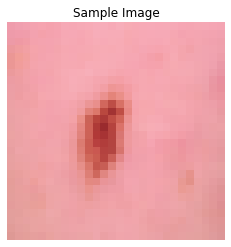

In [48]:
# Reshape the 784-length vector into a 28x28 3D array
plt.imshow(test_images[19].reshape(28, 28, 3))
plt.title("Sample Image")
plt.axis('off')  # Optional: hide axes
plt.savefig(f'Sample Image.jpg')
plt.show()

## MODEL DEVELOPMENT

In [49]:
#create list to hold the model, test accuracy, train accuracy, precision and recall
model=[]
test_accuracy=[]
trained_accuracy=[]
precision=[]
recall=[]

In [50]:
#create a function to handle model evaluation
def model_evalu(Y_test,Y_pred):
    #obtain the confusion matrix on the predicted Data Set
    confu_matrix=confusion_matrix(Y_test,Y_pred)
    #visualize the confusion matrix on the predicted Data Set
    Diagram=ConfusionMatrixDisplay.from_predictions(Y_test,Y_pred)
    #obtain the model accuracy on the predicted Data Set
    Model_accuracy=accuracy_score(Y_test,Y_pred)
    #obtain the classification report on the predicted Data Set
    class_report=classification_report(Y_test,Y_pred, zero_division=0)
    #obtain the values from the confusion matrix
    True_negative=confu_matrix[0,0]
    True_positive=confu_matrix[1,1]
    False_negative=confu_matrix[1,0]
    False_positive=confu_matrix[0,1]
    #obtain rate of predicting true positive
    sensitivity=True_positive/(True_positive+False_negative)
#     #obtain rate of predicting true negative
    if (True_negative + False_positive) == 0:
        specificity = 0  # or float('nan'), or some default value
    else:
        specificity = True_negative / (True_negative + False_positive)


    print(f"Model Accuracy is {Model_accuracy}")
    print(class_report)
    print(f"The rate of predicting true positive is {sensitivity}")
    print(f"The rate of predicting true negative is {specificity}")

In [51]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np
#ceate a function to visulaise the ROC curve
def plot_multiclass_roc(y_true, y_pred_proba, class_names=None, title='ROC Curve - Multi-class Model'):
   
    n_classes = y_pred_proba.shape[1]
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    #set the colour for each label
    plt.figure(figsize=(10, 7))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink'])

    for i, color in zip(range(n_classes), colors):
        label = f'{class_names[i]}' if class_names else f'Class {i}'
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{label} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

## **MULTI-LAYER PERCEPTION (MLP) CLASSIFIER**

In [52]:
train_images = train_images.reshape(train_images.shape[0], -1)
train_labels = train_labels.ravel()

test_images = test_images.reshape(test_images.shape[0], -1)
test_labels = test_labels.ravel()

Precision: 0.0195
Recall: 0.1429
Accuracy on Tuned MLP trained data = 0.1456
Accuracy on Tuned MLP predicted data = 0.1365

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        87
           1       0.00      0.00      0.00        87
           2       0.14      1.00      0.24        86
           3       0.00      0.00      0.00        91
           4       0.00      0.00      0.00        94
           5       0.00      0.00      0.00        83
           6       0.00      0.00      0.00       102

    accuracy                           0.14       630
   macro avg       0.02      0.14      0.03       630
weighted avg       0.02      0.14      0.03       630



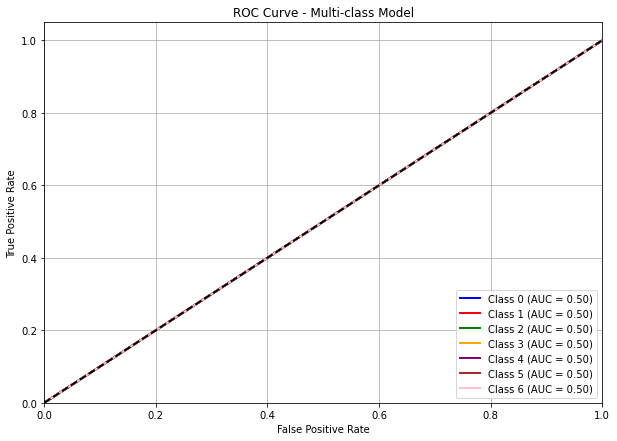

In [53]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    precision_score, recall_score, accuracy_score,
    classification_report, ConfusionMatrixDisplay
)
import numpy as np

# Train MLP model
mlp = MLPClassifier(max_iter=500, hidden_layer_sizes=(30, 15, 20), random_state=42)
mlp.fit(train_images, train_labels)

# Predict labels
Y_actual = mlp.predict(train_images)
Y_pred = mlp.predict(test_images)

# Predict probabilities (for ROC curve)
Y_pred_proba = mlp.predict_proba(test_images)

# Evaluate metrics
accuracy_train = accuracy_score(train_labels, Y_actual)
accuracy_predicted = accuracy_score(test_labels, Y_pred)
precisions = precision_score(test_labels, Y_pred, average='macro', zero_division=0)
recalls = recall_score(test_labels, Y_pred, average='macro', zero_division=0)

# Print metrics
print(f"Precision: {precisions:.4f}")
print(f"Recall: {recalls:.4f}")
print(f"Accuracy on Tuned MLP trained data = {accuracy_train:.4f}")
print(f"Accuracy on Tuned MLP predicted data = {accuracy_predicted:.4f}\n")

# Append to tracking lists
model.append('MLP')
test_accuracy.append(round(accuracy_predicted, 4))
trained_accuracy.append(round(accuracy_train, 4))
precision.append(round(precisions, 4))
recall.append(round(recalls, 4))

# Display classification report and confusion matrix
class_report = classification_report(test_labels, Y_pred, zero_division=0)
print("Classification Report:\n", class_report)

ConfusionMatrixDisplay.from_predictions(test_labels, Y_pred)

# Plot ROC Curve
plot_multiclass_roc(test_labels, Y_pred_proba, class_names=None)

In [54]:
from sklearn.model_selection import GridSearchCV
#function to perform hyperparameter tuning for MLP
def grid_mlp(X_train,X_test,Y_train,Y_test):
    #call the model
    mlp=MLPClassifier(max_iter=500,hidden_layer_sizes=(30,15,20),random_state=42)
    #perform hyperparamter tunning for knn
    param_grid={'activation':['relu','logistic'],'solver':['adam','sgd'],'learning_rate':['constant','adaptive']}
    #fit hyperparameter into gridsearch to automatically tune
    gs=GridSearchCV(mlp,param_grid,scoring='accuracy',cv=10,error_score='raise',n_jobs=-1)
    #fit into the data set
    gs=gs.fit(X_train,Y_train)
    mlp_best=gs.best_estimator_
    #get the best parameters
    best_params=mlp_best.get_params()
    best_activation=best_params['activation']
    best_solver=best_params['solver']
    best_learning_rate=best_params['learning_rate']
    print(f"Best MLPClassifier Parameter: Activation= {best_activation}, Solver= {best_solver}, Learning_rate= {best_learning_rate}")

#call the function
grid_mlp(train_images,test_images,train_labels,test_labels)

Best MLPClassifier Parameter: Activation= logistic, Solver= sgd, Learning_rate= adaptive


Precision: 0.0191
Recall: 0.1429
Accuracy After Hyper-Parameter Tunning
Accuracy on Tuned MLP trained data= 0.1497
Accuracy on Tuned MLP predicted data= 0.1317

Model Accuracy is 0.13174603174603175
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        87
           1       0.00      0.00      0.00        87
           2       0.00      0.00      0.00        86
           3       0.00      0.00      0.00        91
           4       0.00      0.00      0.00        94
           5       0.13      1.00      0.24        83
           6       0.00      0.00      0.00       102

    accuracy                           0.13       630
   macro avg       0.02      0.14      0.03       630
weighted avg       0.02      0.13      0.03       630

The rate of predicting true positive is 0.0
The rate of predicting true negative is 0


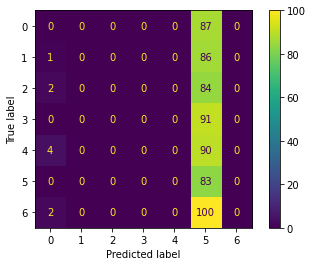

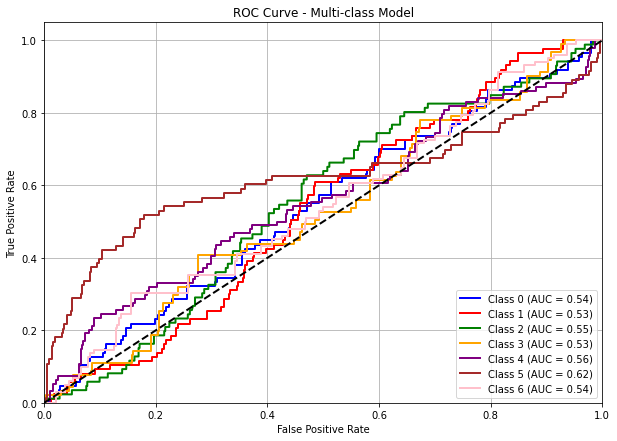

In [55]:
#call the MLP model and fit in the best parameters
mlp=MLPClassifier(max_iter=500,hidden_layer_sizes=(30,15,20),activation='logistic',solver='sgd',learning_rate='adaptive',random_state=42)
#fit the model into the data set
mlp=mlp.fit(train_images,train_labels)
#predict the train data set
Y_actual=mlp.predict(train_images)
#Evaluate accuracy on training data set
accuracy_train=accuracy_score(train_labels,Y_actual)
#predict the test data set   
Y_pred=mlp.predict(test_images)
# Predict probabilities (for ROC curve)
Y_pred_proba = mlp.predict_proba(test_images)

#Evaluate accuracy on the predicted data set
accuracy_predicted=accuracy_score(test_labels,Y_pred)
#Evaluate Precison on the predicted data set
precisions = precision_score(test_labels, Y_pred, average='macro',zero_division=0)
#Evaluate recall on the predicted data set
recalls = recall_score(test_labels, Y_pred, average='macro',zero_division=0)

print(f"Precision: {precisions:.4f}")
print(f"Recall: {recalls:.4f}")

print('Accuracy After Hyper-Parameter Tunning')
print(f"Accuracy on Tuned MLP trained data= {accuracy_train:.4f}")
print(f"Accuracy on Tuned MLP predicted data= {accuracy_predicted:.4f}\n")

#call the model evaluation function
model_evalu(test_labels,Y_pred)
model.append('Tunned MLP')
precision.append(round(precisions, 4))
recall.append(round(recalls, 4))
test_accuracy.append(round(accuracy_predicted, 4))
trained_accuracy.append(round(accuracy_train, 4))
# Plot ROC Curve
plot_multiclass_roc(test_labels, Y_pred_proba, class_names=None)

## DATA AUGUMENTATION

In [56]:
# Reshape train_images to image format
train_images_reshaped = train_images.reshape(-1, 28, 28, 3)

In [57]:
# Define augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.2  # Split part for validation
)

# Create the augmented iterator
augmented_iter = datagen.flow(train_images_reshaped, train_labels, batch_size=len(train_images), shuffle=False)
augmented_images, augmented_labels = next(augmented_iter)


Precision: 0.0188
Recall: 0.1429
Train Accuracy: 0.14761904761904762
Test Accuracy: 0.13174603174603175
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        87
           1       0.00      0.00      0.00        87
           2       0.00      0.00      0.00        86
           3       0.00      0.00      0.00        91
           4       0.00      0.00      0.00        94
           5       0.13      1.00      0.23        83
           6       0.00      0.00      0.00       102

    accuracy                           0.13       630
   macro avg       0.02      0.14      0.03       630
weighted avg       0.02      0.13      0.03       630



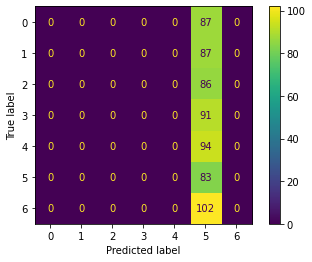

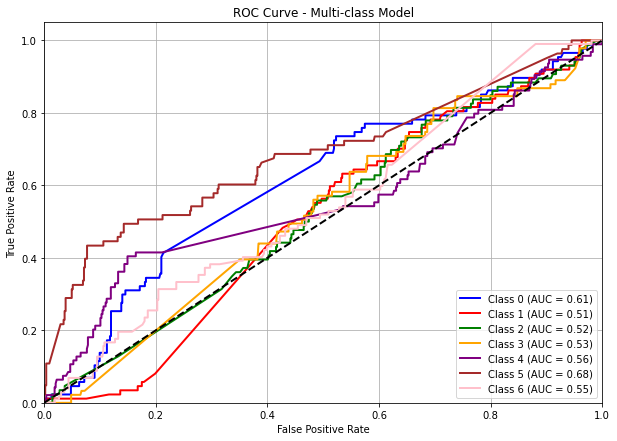

In [58]:
# Combine original and augmented
X_augmented = np.concatenate((train_images_reshaped, augmented_images), axis=0)
y_augmented = np.concatenate((train_labels, augmented_labels), axis=0)

# Flatten for MLP
X_augmented_flat = X_augmented.reshape(X_augmented.shape[0], -1)
test_images_flat = test_images.reshape(test_images.shape[0], -1)

# Train MLP
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

mlp = MLPClassifier(
    activation='logistic',
    max_iter=500,
    hidden_layer_sizes=(30, 15, 20),
    solver='sgd', learning_rate='adaptive',
    random_state=42
)

mlp.fit(X_augmented_flat, y_augmented)

# Evaluate
train_pred = mlp.predict(X_augmented_flat)
test_pred = mlp.predict(test_images_flat)
# Predict probabilities (for ROC curve)
Y_pred_proba = mlp.predict_proba(test_images)

train_acc = accuracy_score(y_augmented, train_pred)
test_acc = accuracy_score(test_labels, test_pred)
#Evaluate Precison on the predicted data set
precisions = precision_score(test_labels, test_pred, average='macro',zero_division=0)
#Evaluate recall on the predicted data set
recalls = recall_score(test_labels, test_pred, average='macro',zero_division=0)

Diagram=ConfusionMatrixDisplay.from_predictions(test_labels, test_pred)
print(f"Precision: {precisions:.4f}")
print(f"Recall: {recalls:.4f}")

print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)
print("Classification Report:\n", classification_report(test_labels, test_pred, zero_division=0))
model.append('Data agumented MLP')
trained_accuracy.append(round(train_acc, 4))
test_accuracy.append(round(test_acc, 4))
precision.append(round(precisions, 4))
recall.append(round(recalls, 4))
# Plot ROC Curve
plot_multiclass_roc(test_labels, Y_pred_proba, class_names=None)

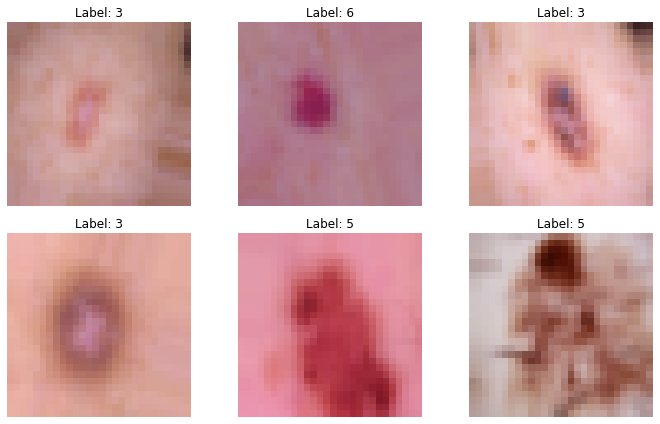

In [59]:
import matplotlib.pyplot as plt
# Recreate the iterator if needed
augmented_iter = datagen.flow(train_images_reshaped, train_labels, batch_size=6, shuffle=True)

# Get a fresh small batch just for visualization
x_batch, y_batch = next(augmented_iter)

# Plot the first 6 augmented images
plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    img = x_batch[i]

    # Clip and convert
    if img.max() > 1.0:
        img = img.astype("float32") / 255.0
    img = img.clip(0, 1)

    # Display based on shape
    if img.shape[-1] == 1:
        plt.imshow(img.squeeze(), cmap='gray')
    else:
        plt.imshow(img)
        
    plt.title(f"Label: {y_batch[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


## **ENSEMBLE LEARNING**

## **Bagging Method**

Precision: 0.0188
Recall: 0.1429
Train Accuracy (Ensemble MLP): 0.1476
Test Accuracy (Ensemble MLP): 0.1317
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        87
           1       0.00      0.00      0.00        87
           2       0.00      0.00      0.00        86
           3       0.00      0.00      0.00        91
           4       0.00      0.00      0.00        94
           5       0.13      1.00      0.23        83
           6       0.00      0.00      0.00       102

    accuracy                           0.13       630
   macro avg       0.02      0.14      0.03       630
weighted avg       0.02      0.13      0.03       630



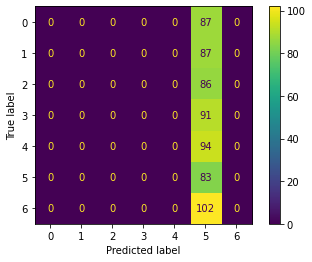

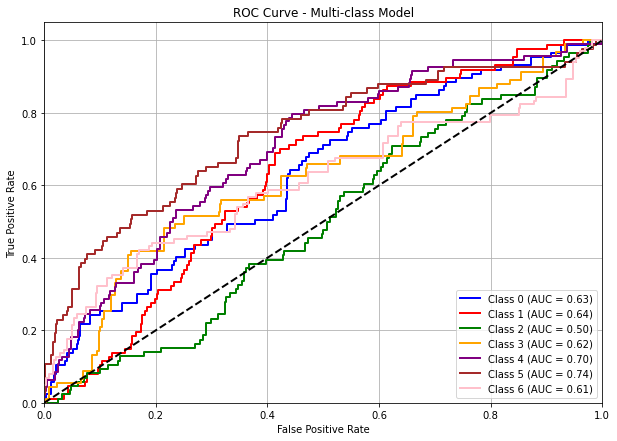

In [60]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define the base MLP model
base_mlp = MLPClassifier(
    activation='logistic',
    max_iter=500,
    hidden_layer_sizes=(30, 15, 20),
    solver='sgd',
    learning_rate='adaptive'
)

# Define the bagging ensemble
ensemble_mlp = BaggingClassifier(
    estimator=base_mlp,
    n_estimators=10,             # Number of MLP models in the ensemble
    max_samples=0.7,             # Each model trains on 70% of the data
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,                   # Use all processors
    random_state=42
)

# Train the ensemble
ensemble_mlp.fit(train_images, train_labels)

# Predictions
y_train_pred = ensemble_mlp.predict(train_images)
y_test_pred = ensemble_mlp.predict(test_images)

# Accuracy
train_acc = accuracy_score(train_labels, y_train_pred)
test_acc = accuracy_score(test_labels, y_test_pred)
# Predict probabilities (for ROC curve)
Y_pred_proba = ensemble_mlp.predict_proba(test_images)
#Evaluate Precison on the predicted data set
precisions = precision_score(test_labels, y_test_pred, average='macro',zero_division=0)
#Evaluate recall on the predicted data set
recalls = recall_score(test_labels, y_test_pred, average='macro',zero_division=0)

print(f"Precision: {precisions:.4f}")
print(f"Recall: {recalls:.4f}")

print(f"Train Accuracy (Ensemble MLP): {train_acc:.4f}")
print(f"Test Accuracy (Ensemble MLP): {test_acc:.4f}")

# Classification Report
report = classification_report(test_labels, y_test_pred, zero_division=0)
print(report)
Diagram=ConfusionMatrixDisplay.from_predictions(test_labels, y_test_pred)
# Optional: append to performance tracking
model.append('Ensemble MLP')
trained_accuracy.append(round(train_acc, 4))
test_accuracy.append(round(test_acc, 4))
precision.append(round(precisions, 4))
recall.append(round(recalls, 4))
# Plot ROC Curve
plot_multiclass_roc(test_labels, Y_pred_proba, class_names=None)

## **CONVOLUTIONAL NEURAL NETWORK**

In [61]:
# Scale images to the [0, 1] range
c_train_images = train_images / 255.0
c_test_images = test_images / 255.0


output_classes= 7

# Make sure images have shape (28, 28, 1)
c_train_images = c_train_images.reshape(-1, 28, 28, 3)
c_test_images = c_test_images.reshape(-1, 28, 28, 3)

In [62]:
cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.5),
    
    Dense(output_classes, activation='softmax')
])

cnn.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 1152)              0

In [63]:
cnn.fit(c_train_images,train_labels, epochs=10, batch_size=128, 
                    validation_split=0.2, verbose=2)

Epoch 1/10
10/10 - 4s - loss: 1.9537 - accuracy: 0.1505 - val_loss: 1.8927 - val_accuracy: 0.2381 - 4s/epoch - 386ms/step
Epoch 2/10
10/10 - 0s - loss: 1.9581 - accuracy: 0.2381 - val_loss: 1.8381 - val_accuracy: 0.2551 - 77ms/epoch - 8ms/step
Epoch 3/10
10/10 - 0s - loss: 1.8476 - accuracy: 0.2491 - val_loss: 1.7861 - val_accuracy: 0.3265 - 76ms/epoch - 8ms/step
Epoch 4/10
10/10 - 0s - loss: 1.8500 - accuracy: 0.2509 - val_loss: 1.8559 - val_accuracy: 0.2075 - 75ms/epoch - 7ms/step
Epoch 5/10
10/10 - 0s - loss: 1.7753 - accuracy: 0.3121 - val_loss: 2.1354 - val_accuracy: 0.1973 - 74ms/epoch - 7ms/step
Epoch 6/10
10/10 - 0s - loss: 1.8070 - accuracy: 0.2908 - val_loss: 1.8844 - val_accuracy: 0.2993 - 75ms/epoch - 8ms/step
Epoch 7/10
10/10 - 0s - loss: 1.7705 - accuracy: 0.3104 - val_loss: 1.7857 - val_accuracy: 0.2755 - 75ms/epoch - 8ms/step
Epoch 8/10
10/10 - 0s - loss: 1.7463 - accuracy: 0.2976 - val_loss: 1.6655 - val_accuracy: 0.3776 - 73ms/epoch - 7ms/step
Epoch 9/10
10/10 - 0s - 

In [64]:
from sklearn.metrics import (
    classification_report, precision_score, recall_score,
    accuracy_score, ConfusionMatrixDisplay
)
import numpy as np

# Predict on test set (probabilities and labels)
y_pred_test_proba = cnn.predict(c_test_images)
y_pred_test = np.argmax(y_pred_test_proba, axis=1)

# Predict on train set
y_pred_train_proba = cnn.predict(c_train_images)
y_pred_train = np.argmax(y_pred_train_proba, axis=1)

# Classification report
class_report = classification_report(test_labels, y_pred_test, zero_division=0)
print("Classification Report (Test):\n", class_report)

# Confusion matrix
Diagram = ConfusionMatrixDisplay.from_predictions(test_labels, y_pred_test)

# Metrics
precisions = precision_score(test_labels, y_pred_test, average='macro', zero_division=0)
recalls = recall_score(test_labels, y_pred_test, average='macro', zero_division=0)
acc_test = accuracy_score(test_labels, y_pred_test)
acc_train = accuracy_score(train_labels, y_pred_train)

# Output metrics
print(f"Precision (Test): {precisions:.4f}")
print(f"Recall (Test): {recalls:.4f}")
print(f"Accuracy (Test): {acc_test:.4f}")
print(f"Accuracy (Train): {acc_train:.4f}")

# Append to model tracking
model.append('CNN')
precision.append(round(precisions, 4))
recall.append(round(recalls, 4))
test_accuracy.append(round(acc_test, 4))
trained_accuracy.append(round(acc_train, 4))

# Plot ROC Curve using predicted probabilities
plot_multiclass_roc(test_labels, y_pred_test_proba, class_names=None)

46/46 [==============================] - 0s 2ms/step
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        87
           1       0.19      0.09      0.12        87
           2       0.24      0.33      0.28        86
           3       0.31      0.04      0.08        91
           4       0.31      0.72      0.43        94
           5       0.64      0.19      0.30        83
           6       0.39      0.81      0.53       102

    accuracy                           0.33       630
   macro avg       0.30      0.31      0.25       630
weighted avg       0.30      0.33      0.25       630

Precision (Test): 0.2963
Recall (Test): 0.3131
Accuracy (Test): 0.3286
Accuracy (Train): 0.3463


C:\Users\n1322617\AppData\Local\Temp/ipykernel_5056/3721816760.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  cnn = KerasClassifier(build_fn=build_model, verbose=0)


20/20 [==============================] - 0s 2ms/step
Best Parameters: {'batch_size': 128, 'dropout_rate': 0.3, 'epochs': 10, 'optimizer': 'adam'}
Train Accuracy: 0.4714
Test Accuracy: 0.4365
Train Precision: 0.4853
Test Precision: 0.4617
Train Recall: 0.4722
Test Recall: 0.4349

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.35      0.36      0.35        87
           1       0.38      0.44      0.40        87
           2       0.33      0.34      0.34        86
           3       0.33      0.38      0.36        91
           4       0.45      0.44      0.44        94
           5       0.47      0.55      0.51        83
           6       0.92      0.54      0.68       102

    accuracy                           0.44       630
   macro avg       0.46      0.43      0.44       630
weighted avg       0.47      0.44      0.45       630



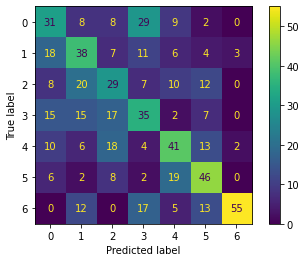

In [65]:
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop

# Model-building function
def build_model(optimizer='adam', dropout_rate=0.5):
    cnn = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(output_classes, activation='softmax')
    ])
    cnn.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    return cnn

# Wrap model
cnn = KerasClassifier(build_fn=build_model, verbose=0)

# GridSearchCV
param_grid = {
    'batch_size': [128],
    'epochs': [10],
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.3, 0.5]
}

# Fit the grid
grid = GridSearchCV(estimator=cnn, param_grid=param_grid, cv=2)
grid_train = grid.fit(c_train_images, train_labels)

# Evaluate best model on test data
best_model = grid.best_estimator_

# Predictions
y_pred_test = best_model.predict(c_test_images)
y_pred_train = best_model.predict(c_train_images)

# Predictions (probabilities for ROC curve)
y_pred_test_proba = best_model.predict_proba(c_test_images)

# Compute scores
precision_test = precision_score(test_labels, y_pred_test, average='macro', zero_division=0)
recall_test = recall_score(test_labels, y_pred_test, average='macro', zero_division=0)
acc_test = accuracy_score(test_labels, y_pred_test)

precision_train = precision_score(train_labels, y_pred_train, average='macro', zero_division=0)
recall_train = recall_score(train_labels, y_pred_train, average='macro', zero_division=0)
acc_train = accuracy_score(train_labels, y_pred_train)

# Print scores
# Output best parameters
print("Best Parameters:", grid.best_params_)
print("Train Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))
print("Train Precision:", round(precision_train, 4))
print("Test Precision:", round(precision_test, 4))
print("Train Recall:", round(recall_train, 4))
print("Test Recall:", round(recall_test, 4))

# Append to lists
model.append('Tunned CNN')
trained_accuracy.append(round(acc_train, 4))
test_accuracy.append(round(acc_test, 4))
precision.append(round(precision_test, 4))
recall.append(round(recall_test, 4))

# Classification report (optional)
print("\nClassification Report (Test):\n", classification_report(test_labels, y_pred_test, zero_division=0))
Diagram=ConfusionMatrixDisplay.from_predictions(test_labels, y_pred_test)
plot_multiclass_roc(test_labels, y_pred_test_proba, class_names=None)

In [66]:
import matplotlib.pyplot as plt

# === Visualization of Cross-Validation Accuracy ===
# Extract mean test scores and parameter combinations
mean_test_scores = grid.cv_results_['mean_test_score']
params = grid.cv_results_['params']

# Create readable labels for each combination
labels = [f"{p['optimizer']}, dropout={p['dropout_rate']}" for p in params]

# Plot horizontal bar chart
plt.figure(figsize=(8, 6))
plt.barh(labels, mean_test_scores, color='green')
plt.xlabel('Cross-Validation Accuracy',fontsize=13)
plt.title('Grid Search Accuracy by Hyperparameter Combination',fontsize=13)
plt.xticks(rotation=45, fontsize=13)
plt.yticks(fontsize=13)
plt.gca().invert_yaxis()  # Best score on top
plt.tight_layout()

# Show and save plot
plt.show()
plt.savefig('Cross-Validation_Accuracy.png')

<Figure size 432x288 with 0 Axes>

## Data Agumentation for CNN

Epoch 1/10
10/10 - 1s - loss: 1.9525 - accuracy: 0.1522 - val_loss: 1.9160 - val_accuracy: 0.1463 - 1s/epoch - 103ms/step
Epoch 2/10
10/10 - 0s - loss: 1.9097 - accuracy: 0.1981 - val_loss: 1.8782 - val_accuracy: 0.2653 - 453ms/epoch - 45ms/step
Epoch 3/10
10/10 - 0s - loss: 1.9148 - accuracy: 0.2117 - val_loss: 1.8329 - val_accuracy: 0.2177 - 452ms/epoch - 45ms/step
Epoch 4/10
10/10 - 0s - loss: 1.8536 - accuracy: 0.2389 - val_loss: 1.9615 - val_accuracy: 0.1735 - 455ms/epoch - 46ms/step
Epoch 5/10
10/10 - 0s - loss: 1.8147 - accuracy: 0.2568 - val_loss: 1.8785 - val_accuracy: 0.1905 - 451ms/epoch - 45ms/step
Epoch 6/10
10/10 - 0s - loss: 1.8027 - accuracy: 0.2704 - val_loss: 1.7071 - val_accuracy: 0.3605 - 457ms/epoch - 46ms/step
Epoch 7/10
10/10 - 0s - loss: 1.7279 - accuracy: 0.3138 - val_loss: 1.6909 - val_accuracy: 0.3469 - 464ms/epoch - 46ms/step
Epoch 8/10
10/10 - 0s - loss: 1.6904 - accuracy: 0.3316 - val_loss: 1.8553 - val_accuracy: 0.2347 - 460ms/epoch - 46ms/step
Epoch 9/10

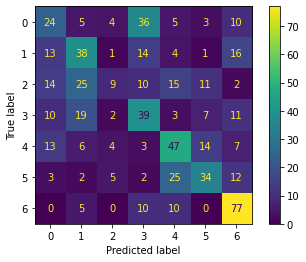

In [67]:
# Data Augmentation for training
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.2  # Split part for validation
)

# Create generators
train_generator = datagen.flow(c_train_images, train_labels, batch_size=128, subset='training')
val_generator = datagen.flow(c_train_images, train_labels, batch_size=128, subset='validation')

# CNN Architecture
cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(output_classes, activation='softmax')
])

cnn.compile(optimizer='rmsprop',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

# Train with augmented data
cnn.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    verbose=2
)

# Predict on test set
y_pred_test = cnn.predict(c_test_images)
y_pred_test = np.argmax(y_pred_test, axis=1)

# Predict on train set
y_pred_train = cnn.predict(c_train_images)
y_pred_train = np.argmax(y_pred_train, axis=1)

y_pred_test_proba = cnn.predict(c_test_images)
# Classification report for test
class_report = classification_report(test_labels, y_pred_test, zero_division=0)
print("Classification Report (Test):\n", class_report)
Diagram=ConfusionMatrixDisplay.from_predictions(test_labels, y_pred_test)
# Compute metrics
precisions = precision_score(test_labels, y_pred_test, average='macro', zero_division=0)
recalls = recall_score(test_labels, y_pred_test, average='macro', zero_division=0)
acc_test = accuracy_score(test_labels, y_pred_test)
acc_train = accuracy_score(train_labels, y_pred_train)

# Print metrics

print(f"Precision (Test): {precisions:.4f}")
print(f"Recall (Test): {recalls:.4f}")
print(f"Accuracy (Test): {acc_test:.4f}")
print(f"Accuracy (Train): {acc_train:.4f}")

# Append to your tracking lists
model.append('Data agumented CNN')
precision.append(round(precisions, 4))
recall.append(round(recalls, 4))
test_accuracy.append(round(acc_test, 4))
trained_accuracy.append(round(acc_train, 4))
# Plot ROC Curve using predicted probabilities
plot_multiclass_roc(test_labels, y_pred_test_proba, class_names=None)

## **Microsoft Custom Vision**

In [90]:
import requests
import json
from PIL import Image
import io

# obtain azure details
prediction_key = "AdPazKdeBU5yyXYfJvBp3pxdK0bJwyp403zXzGKk8JuVGm6q5SbbJQQJ99BFACYeBjFXJ3w3AAAIACOGpH3o"
endpoint = "https://lesionvision-prediction.cognitiveservices.azure.com/customvision/v3.0/Prediction/266ff73c-09bd-4750-8059-8879b546c457/classify/iterations/LesionModel-v1/image"

# Load your image
image_path = "./lesion_images/0/image_0.jpg"

with open(image_path, "rb") as image_file:
    image_data = image_file.read()

headers = {
    "Prediction-Key": prediction_key,
    "Content-Type": "application/octet-stream"
}

# Send image to Azure for prediction
response = requests.post(endpoint, headers=headers, data=image_data)
response.raise_for_status()

# Parse response
results = response.json()
print("Prediction Results:")
for prediction in results["predictions"]:
    tag = prediction["tagName"]
    prob = prediction["probability"]
    print(f"{tag}: {prob:.2%}")

Prediction Results:
0: 82.77%
1: 11.41%
2: 2.89%
3: 1.07%
4: 1.05%
5: 0.77%
6: 0.04%


## **ACCURACY VISUALIZATION**

In [69]:
data={'Model':model, 'Precision':precision, 'Recall':recall ,'Train Accuracy':trained_accuracy ,'Test Accuracy':test_accuracy}
df2=pd.DataFrame(data)
df2

Model  Precision  Recall  Train Accuracy  Test Accuracy
0                 MLP     0.0195  0.1429          0.1456         0.1365
1          Tunned MLP     0.0191  0.1429          0.1497         0.1317
2  Data agumented MLP     0.0188  0.1429          0.1476         0.1317
3        Ensemble MLP     0.0188  0.1429          0.1476         0.1317
4                 CNN     0.2963  0.3131          0.3463         0.3286
5          Tunned CNN     0.4617  0.4349          0.4714         0.4365
6  Data agumented CNN     0.4116  0.4158          0.4374         0.4254

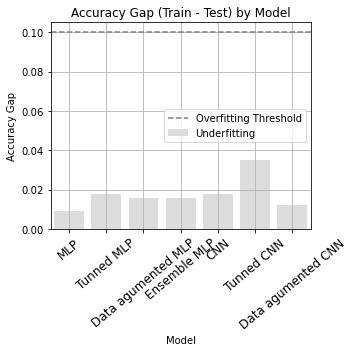

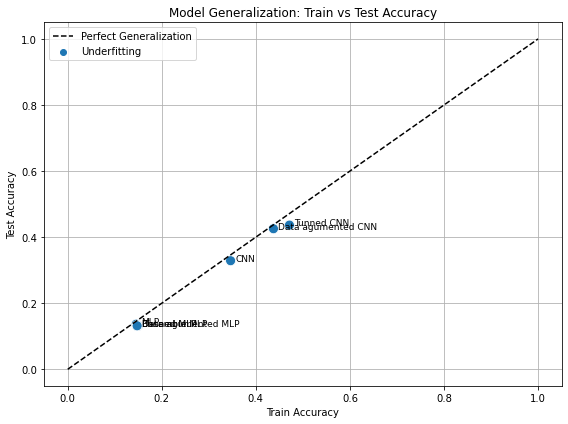

In [70]:
df2['Gap'] = df2['Train Accuracy'] - df2['Test Accuracy']

# Classification of model fit
def classify_fit(row):
    if row['Train Accuracy'] < 0.6 and row['Test Accuracy'] < 0.6:
        return 'Underfitting'
    elif row['Gap'] > 0.1:
        return 'Overfitting'
    else:
        return 'Good Fit'

df2['Fit Type'] = df2.apply(classify_fit, axis=1)

#Bar Plot: Overfitting Gap (Train - Test)
plt.figure(figsize=(5, 5))
sns.barplot(data=df2, x='Model', y='Gap', hue='Fit Type', palette='coolwarm')
plt.axhline(0.1, color='gray', linestyle='--', label='Overfitting Threshold')
plt.axhline(0, color='black', linewidth=0.5)
plt.title("Accuracy Gap (Train - Test) by Model")
plt.xticks(rotation=40, fontsize=12) 
plt.ylabel("Accuracy Gap")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'Model Evaluation 2.jpg')
plt.show()


#Scatter Plot: Generalization View
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df2, x='Train Accuracy', y='Test Accuracy', hue='Fit Type', s=100, style='Fit Type')

# Add diagonal reference line (ideal generalization)
plt.plot([0, 1], [0, 1], 'k--', label='Perfect Generalization')

# Annotate points
for _, row in df2.iterrows():
    plt.text(row['Train Accuracy'] + 0.01, row['Test Accuracy'], row['Model'], fontsize=9)

plt.title("Model Generalization: Train vs Test Accuracy")
plt.xlabel("Train Accuracy")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f'Model Evaluation 3.jpg')
plt.show()

In [71]:
# Create a new row as a dictionary
new_row = {
    'Model': 'Microsoft Custom Vision',
    'Train Accuracy': 0.68,
    'Test Accuracy': 0.82,
    'Precision': 0.67,
    'Recall': 0.56
}

# Append the new row to the DataFrame
df2 = pd.concat([df2, pd.DataFrame([new_row])], ignore_index=True)
df2

Model  Precision  Recall  Train Accuracy  Test Accuracy  \
0                      MLP     0.0195  0.1429          0.1456         0.1365   
1               Tunned MLP     0.0191  0.1429          0.1497         0.1317   
2       Data agumented MLP     0.0188  0.1429          0.1476         0.1317   
3             Ensemble MLP     0.0188  0.1429          0.1476         0.1317   
4                      CNN     0.2963  0.3131          0.3463         0.3286   
5               Tunned CNN     0.4617  0.4349          0.4714         0.4365   
6       Data agumented CNN     0.4116  0.4158          0.4374         0.4254   
7  Microsoft Custom Vision     0.6700  0.5600          0.6800         0.8200   

      Gap      Fit Type  
0  0.0091  Underfitting  
1  0.0180  Underfitting  
2  0.0159  Underfitting  
3  0.0159  Underfitting  
4  0.0177  Underfitting  
5  0.0349  Underfitting  
6  0.0120  Underfitting  
7     NaN           NaN

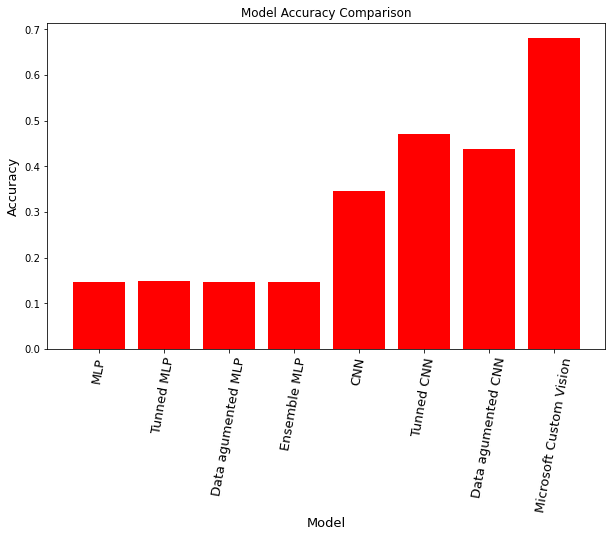

In [72]:
plt.figure(figsize=(10, 6))
#bar chart to display training model accuracy 
plt.bar(df2["Model"],df2['Train Accuracy'], color='red')
plt.xlabel("Model", fontsize=13)
plt.ylabel("Accuracy", fontsize=13)
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=80,fontsize=13)
plt.savefig(f'Model Evaluation 4.jpg')
plt.show()

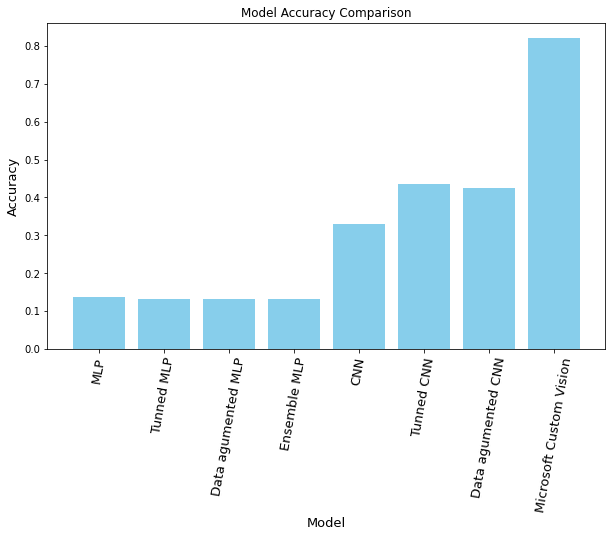

In [73]:
plt.figure(figsize=(10, 6))
#bar chart to display test accuracy
plt.bar(df2["Model"],df2['Test Accuracy'], color='skyblue')
plt.xlabel("Model", fontsize=13)
plt.ylabel("Accuracy", fontsize=13)
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=80,fontsize=13)
plt.savefig(f'Model Evaluation 4.jpg')
plt.show()

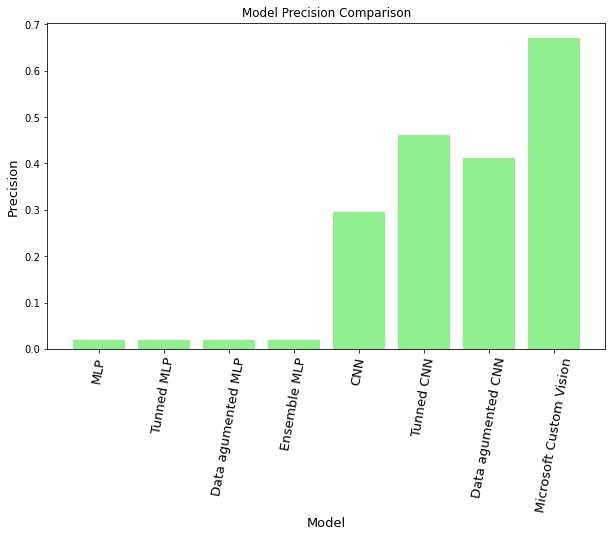

In [74]:
plt.figure(figsize=(10, 6))
#bar chart to plot precision
plt.bar(df2["Model"],df2['Precision'], color='lightgreen')
plt.xlabel("Model",fontsize=13)
plt.ylabel("Precision", fontsize=13)
plt.title("Model Precision Comparison")
plt.xticks(rotation=80, fontsize=13)
plt.savefig(f'Model Evaluation 5.jpg')
plt.show()

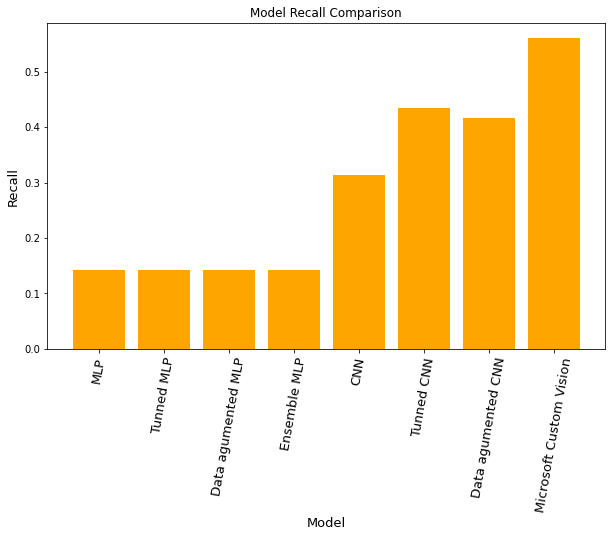

In [75]:
plt.figure(figsize=(10, 6))
#bar chart to plot the recall
plt.bar(df2["Model"],df2['Recall'], color='orange')
plt.xlabel("Model", fontsize=13)
plt.ylabel("Recall", fontsize=13)
plt.title("Model Recall Comparison")
plt.xticks(rotation=80, fontsize=13)
plt.savefig(f'Model Evaluation 6.jpg')
plt.show()

## **CLUSTERING**

In [76]:
from sklearn.cluster import KMeans 
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.stats import mode

k=7
images_np = images_copy
labels = labels_copy
#set the kmeans parameters
kmeans = KMeans(n_clusters=k, random_state=42,n_init=10, init='k-means++')
clusters = kmeans.fit_predict(images_np)

In [77]:
#obtain the cluster centers
kmeans.cluster_centers_

array([[139.58422939, 112.3655914 , 119.49462366, ..., 118.12903226,
         93.03942652,  98.94982079],
       [179.28571429, 148.64285714, 157.19642857, ..., 181.68452381,
        149.4047619 , 157.68452381],
       [151.56207675, 116.35440181, 121.40406321, ..., 137.02708804,
        103.48532731, 108.27990971],
       ...,
       [201.87931034, 170.50344828, 179.8       , ..., 194.6137931 ,
        163.55862069, 172.36206897],
       [207.33260394, 153.07877462, 161.10503282, ..., 199.16630197,
        148.88183807, 152.0940919 ],
       [ 55.76666667,  39.49333333,  43.36666667, ...,  55.71333333,
         39.60666667,  43.92      ]])

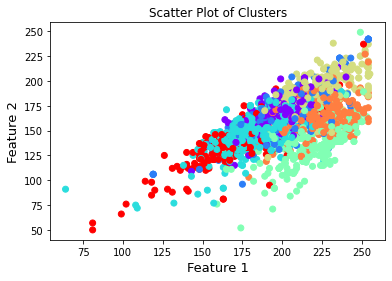

In [78]:
import matplotlib.pyplot as plt
#plot a scatter plot to show the clusters
plt.scatter(images_np[:, 30], images_np[:, 31], c=clusters, cmap='rainbow')
plt.xlabel('Feature 1', fontsize=13)
plt.ylabel('Feature 2', fontsize=13)
plt.title('Scatter Plot of Clusters')
plt.savefig(f'Cluster Scatter.jpg')
plt.show()

In [79]:
import numpy as np
from scipy.stats import mode

def map_clusters_to_labels(y_true, y_clusters):
    y_true = np.array(y_true)          # Convert to NumPy array
    y_clusters = np.array(y_clusters)  # Ensure clusters are NumPy array
    labels = np.zeros_like(y_clusters)

    for i in range(np.max(y_clusters) + 1):
        mask = (y_clusters == i)
        if np.any(mask):  # Ensure mask has True values
            labels[mask] = mode(y_true[mask])[0][0]  # Get most common true label

    return labels

In [80]:
y_pred = map_clusters_to_labels(labels, clusters)

In [81]:
from sklearn.metrics import accuracy_score
#obtain the accuracy of the cluster label
print("Accuracy:", accuracy_score(labels, y_pred))

Accuracy: 0.2985714285714286


In [82]:
from yellowbrick.cluster import KElbowVisualizer
#call Kmeans
model=KMeans(init='k-means++',random_state=10,tol=1e-04,n_init=10,max_iter=400)
#visualize the model
display=KElbowVisualizer(model,k=(1,20))
#fit the visualizer into data set
display.fit(images_np)
plt.savefig(f'Kmean.jpg')
display.show()

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [83]:
from sklearn.metrics import silhouette_score
#obtain the silhouette score
score = silhouette_score(images_np, clusters)
print("Silhouette Score:", score)

Silhouette Score: 0.10240413853115522


In [84]:
from yellowbrick.cluster import SilhouetteVisualizer
k=5
k_means=KMeans(random_state=10,init='k-means++',n_clusters=k,tol=1e-04,n_init=10,max_iter=400)
display=SilhouetteVisualizer(k_means,colours="yellowbrick")
display.fit(images_np)
plt.savefig(f'Shilhouette.jpg')
display.show()

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 2100 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [85]:
import numpy as np
from sklearn.metrics import homogeneity_score
#obtain the homogenity score
score = homogeneity_score(labels, clusters)
print(f"Homogeneity Score: {score:.4f}")

Homogeneity Score: 0.0919


In [86]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
#obtain the adjusted rand and normalised_mutual_info score
ari = adjusted_rand_score(labels, clusters)
nmi = normalized_mutual_info_score(labels, clusters)

print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Normalized Mutual Info: {nmi:.4f}")

Adjusted Rand Index: 0.0540
Normalized Mutual Info: 0.0935


## **Hierarchial Clustering**

In [87]:
#perform the hierarchial clustering
from sklearn.cluster import AgglomerativeClustering
agglo_cluster=AgglomerativeClustering(n_clusters=5,metric='euclidean',linkage='ward')
#fit and predict the cluster label
cluster_label=agglo_cluster.fit_predict(images_np)

In [88]:
y_pred = map_clusters_to_labels(labels, cluster_label)
#accuracy of the agglomerative cluster label
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(labels, y_pred))

Accuracy: 0.2804761904761905


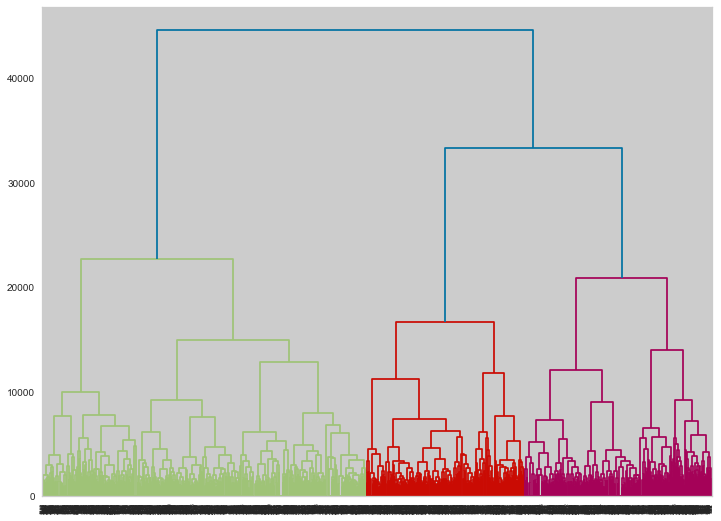

In [89]:
#plotting the dendogram
from scipy.cluster.hierarchy import dendrogram,linkage
#calculate the linkage matrix
linkage_matrix=linkage(images_np,'ward')
#create a figure and axis
plt.figure(figsize=(12,9))
#plot the dendogram
dendrogram(linkage_matrix)
plt.savefig(f'Dendogram.jpg')
plt.show() 